---
title: "Auditing Bias"
author: "Yahya Rahhawi"
date: "2025-03-21"
categories: [Machine Learning, Bias, Fairness]
format:
  html:
    toc: true
    code-fold: false
---

In [1]:
from folktables import ACSDataSource, BasicProblem
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression

# Load and Prepare Data

Here we are downloading the dataset using `folktables`, then we define a classification problem to predict whether an individual's income exceeds $50K. We exclude `SEX` and `PINCP` from the feature set to avoid bias and prepare the dataset by converting it into NumPy arrays. Finally, we split the data into training (80%) and testing (20%) sets.

In [2]:
possible_features=['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']
STATE = "MI"
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=[STATE], download=True)

In [ ]:
# Features excluding sex (and income, which will be the target)
features_to_use = [f for f in possible_features if f not in ["PINCP", "SEX"]]

# Define the problem
IncomeProblem = BasicProblem(
    features=features_to_use,
    target='PINCP',
    target_transform=lambda x: x > 50000,
    group='SEX',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

# Extract data
features, label, group = IncomeProblem.df_to_numpy(acs_data)

#  train-test split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0
)

now we are creating a structured DataFrame from the training data to facilitate analysis and visualization. First, we define mapping dictionaries to convert numerical codes for `SEX` and `RAC1P` into human-readable labels. Then, we construct the DataFrame using `X_train` and add key columns:  

- **`group`**: Represents `SEX`, coded as 1 (Male) and 2 (Female).  
- **`label`**: Indicates whether an individual's income exceeds $50K (binary target).  
- **`Gender`**: A mapped version of `group` for readability.  

For this blog post, I have chosen **gender as the grouping variable** to explore potential biases in income predictions. This DataFrame will help analyze demographic trends and disparities in the dataset.

In [ ]:
# Mapping dictionaries for human-readable labels. I have modified the labels for race for easier visualization
sex_map = {1: "M", 2: "F"}
race_map = {
    1: "White",
    2: "Black",
    3: "Native",
    4: "Asian",
    5: "Native Hawaiian/Pacific Islander",
    6: "Other",
    7: "Two or More"
}

df = pd.DataFrame(X_train, columns=features_to_use)
df["group"] = group_train  # This is the SEX column, coded as 1 or 2.
df["label"] = y_train      # Binary target: 1 indicates income > 50K.
df["Gender"] = df["group"].map(sex_map)

Note: I have summarized the race titles for easier labeling in visualizations. please refer to the source of dataset for full description of races

### Number of individuals 
let's inspect the number of individuals in this dataset

In [5]:
n_individuals = df.shape[0]
print("Total number of individuals:", n_individuals)

Total number of individuals: 79535


### Proportion of Positive Labels

Now let's calculate the proportion of individuals whose income exceeds $50K. Since the `label` column is binary (1 for income > $50K and 0 otherwise), taking its mean gives us the proportion of positive cases in the training data.

In [ ]:
prop_positive = df["label"].mean()  # Since label is binary (0 or 1)
print("Proportion of individuals with label == 1:", prop_positive)

Proportion of individuals with label == 1: 0.19888099578801785


The result shows that approximately **19.89%** of individuals in the training set have an income greater than $50K. This indicates a class imbalance, with a significantly higher number of individuals earning $50K or less. Such imbalance is important to consider, as it can affect the performance and fairness of classification models, potentially leading them to favor the majority class.

### Number of individuals per Gender Group

Now, let's calculates and prints the number of individuals in each gender group within the dataset. The gender groups are represented as "M" for males and "F" for females.

In [ ]:
gender_counts = df["Gender"].value_counts()
print("\nNumber of individuals per Gender:")
print(gender_counts)



Number of individuals per Gender:
Gender
F    40202
M    39333
Name: count, dtype: int64


there are **40,202 females** and **39,333 males**, indicating that the gender groups are fairly balanced in size.

### Proportion of Positive Labels by Gender Group

Now we calculate the proportion of individuals earning over $50K within each gender group. This helps reveal any disparities in income distribution between males and females. By grouping the data by `Gender` and taking the mean of the binary `label`, we find the rate of high-income individuals in each group.

In [ ]:
gender_positive_prop = df.groupby("Gender")["label"].mean()
print("\nProportion of positive labels (label == 1) by Gender:")
print(gender_positive_prop)



Proportion of positive labels (label == 1) by Gender:
Gender
F    0.136411
M    0.262731
Name: label, dtype: float64


The results show a noticeable disparity: **13.64%** of females in the training set earn over $50K compared to **26.27%** of males. This significant gap suggests a gender imbalance in income levels, which is important to keep in mind when evaluating potential bias in the model’s predictions.

## patterns of disparity
To explore deeper patterns of disparity, we now perform an **intersectional analysis** by examining the proportion of individuals earning over $50K across combined gender and race subgroups. We add the `RAC1P` column (race) from the original ACS dataset to our DataFrame and map it to readable race labels using `race_map`.

We then create a new column that combines gender and race into a single intersectional group (e.g., "M & White", "F & Black"). By grouping on this combined variable and computing the mean of the `label`, we obtain the proportion of high-income individuals within each intersectional group.

Finally, we visualize these proportions with a bar chart to better observe the disparities across different gender-race combinations. This helps highlight how overlapping identities can influence economic outcomes and inform fairness analysis in the model.


Proportion of positive labels by Gender & Race group:
Gender_Race
F & Black                               0.143632
F & Native                              0.137795
F & Native Hawaiian/Pacific Islander    0.150943
F & Other                               0.125604
F & Two or More                         0.000000
F & White                               0.136007
M & Black                               0.256418
M & Native                              0.240816
M & Native Hawaiian/Pacific Islander    0.204545
M & Other                               0.287402
M & Two or More                         0.250000
M & White                               0.263107
Name: label, dtype: float64


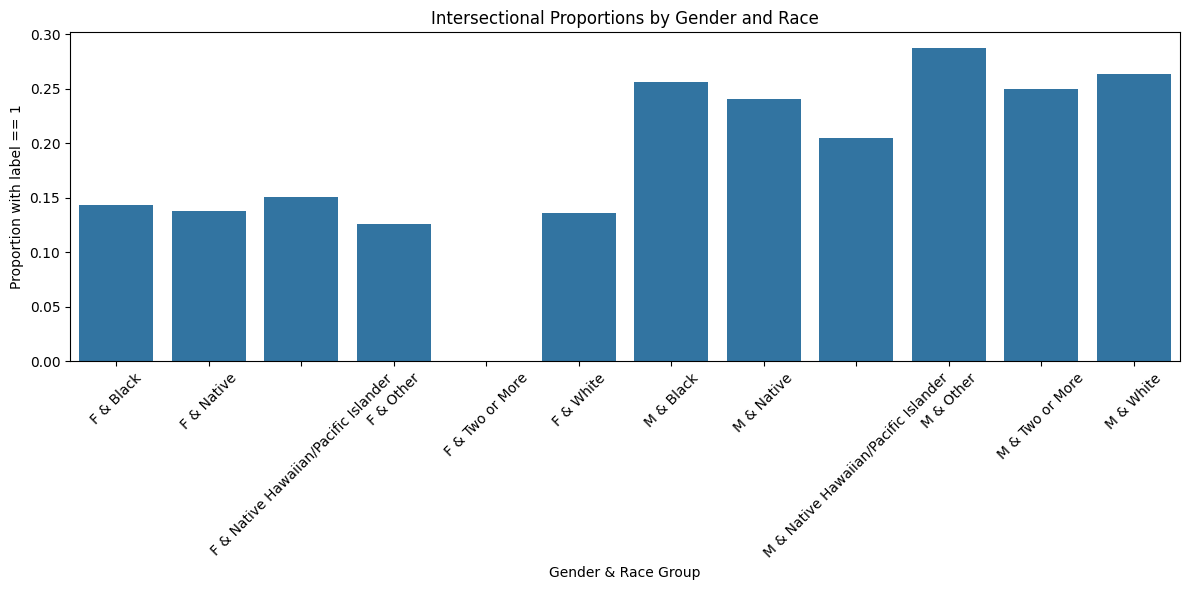

In [16]:
df_intersection = df.copy()
df_intersection["RAC1P"] = acs_data.loc[df.index, "RAC1P"]

# Map RAC1P to human-readable race labels.
df_intersection["Race"] = df_intersection["RAC1P"].map(race_map)

# Create an intersectional grouping variable using both Gender and Race.
df_intersection["Gender_Race"] = df_intersection["Gender"] + " & " + df_intersection["Race"]

# Compute the proportion of positive labels for each intersectional group.
intersectional_stats = df_intersection.groupby("Gender_Race")["label"].mean()
print("\nProportion of positive labels by Gender & Race group:")
print(intersectional_stats)

# Visualize the intersectional trends with a bar chart.
plt.figure(figsize=(12, 6))
sns.barplot(x=intersectional_stats.index, y=intersectional_stats.values)
plt.xlabel("Gender & Race Group")
plt.ylabel("Proportion with label == 1")
plt.title("Intersectional Proportions by Gender and Race")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The results of the intersectional analysis show consistent disparities in high-income proportions across gender and race combinations. For **females**, the proportion of individuals earning over $50K ranges from **12.56% to 15.09%** across most racial groups, with **White females at 13.60%** and **Black females at 14.36%**. Notably, **females identifying as Two or More races** have a value of **0%**, likely due to a very small sample size.

For **males**, the rates are significantly higher across the board. For example, **White males are at 26.31%**, **Black males at 25.64%**, and **Other males at 28.74%**. These findings reinforce the earlier observed gender gap and also highlight how racial identity further compounds disparities. This intersectional breakdown is crucial for understanding how multiple identity factors can interact to affect economic outcomes.

This is why choosing gender might be a good thing to explore bias through in this blog post.

Here we train and tune a `RandomForestClassifier` by performing a hyperparameter search over the `max_depth` parameter. We loop through a range of depths in steps of 2 and use **5-fold cross-validation** to evaluate model performance at each depth.

For each candidate `max_depth`, we compute the average cross-validation accuracy and track it in a dictionary. To avoid unnecessary computation, we stop the search early if the performance begins to drop.

At the end, we identify the best-performing `max_depth` based on the highest mean cross-validation accuracy. This tuned depth will be used to train our final model.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Define the candidate max_depth values.
step, max_val = 2, 20

max_depth_values = [int(i * step) for i in range(1, max_val + 1)]
results = {}

for depth in max_depth_values:
    model = RandomForestClassifier(max_depth=depth, random_state=42)
    
    # Perform 5-fold cross-validation on the training data.
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    mean_score = np.mean(cv_scores)
    results[depth] = mean_score
    
    print(f"Max Depth: {depth} - Mean CV Accuracy: {mean_score:.3f}")
    scores = list(results.values())
    
    #we're finding the minimum number of max_depth values to test
    if len(scores) > 2 and scores[-1] < scores[-2]:
        break


best_depth = max(results, key=results.get)
print("\nBest max_depth:", best_depth, "with a Mean CV Accuracy of:", results[best_depth])

Max Depth: 2 - Mean CV Accuracy: 0.801
Max Depth: 4 - Mean CV Accuracy: 0.842
Max Depth: 6 - Mean CV Accuracy: 0.843
Max Depth: 8 - Mean CV Accuracy: 0.843
Max Depth: 10 - Mean CV Accuracy: 0.844
Max Depth: 12 - Mean CV Accuracy: 0.845
Max Depth: 14 - Mean CV Accuracy: 0.844

Best max_depth: 12 with a Mean CV Accuracy of: 0.8447350223172189


Using the optimal `max_depth` found from cross-validation, we now train a final `RandomForestClassifier` on the full training data. After fitting the model, we evaluate its performance on the test set.

We calculate several key performance metrics:
- **Accuracy**: the proportion of correct predictions.
- **Positive Predictive Value (PPV)**: the precision, or the proportion of predicted positives that are actually positive.
- **False Negative Rate (FNR)**: the proportion of actual positives that were misclassified as negatives.
- **False Positive Rate (FPR)**: the proportion of actual negatives that were misclassified as positives.

These metrics provide a comprehensive view of the model's overall performance.

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score

# start and fit a new model using the best max_depth from tuning
best_model = RandomForestClassifier(max_depth=best_depth, random_state=42)
best_model.fit(X_train, y_train)

# Make predictions on the test data
y_hat = best_model.predict(X_test)

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_hat)

# Compute confusion matrix: returns [[TN, FP], [FN, TP]]
tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()

# Calculate positive predictive value (PPV) i.e. precision
ppv = precision_score(y_test, y_hat)

# Calculate false negative rate (FNR): FN / (FN + TP) while avoiding dividing by zero
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

# Calculate false positive rate (FPR): FP / (FP + TN)
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

print("Overall Accuracy:", accuracy)
print("Positive Predictive Value (PPV):", ppv)
print("False Negative Rate (FNR):", fnr)
print("False Positive Rate (FPR):", fpr)

Overall Accuracy: 0.8486220076443372
Positive Predictive Value (PPV): 0.6697517879680269
False Negative Rate (FNR): 0.5829185223997904
False Positive Rate (FPR): 0.04885790751229228


The model achieves an **overall accuracy of 84.86%**, indicating strong performance in correctly classifying income levels. The **positive predictive value (PPV)** is **66.98%**, meaning that when the model predicts someone earns over $50K, it's correct about two-thirds of the time.

However, the **false negative rate (FNR)** is relatively high at **58.29%**, suggesting that the model frequently fails to identify individuals who do earn more than $50K. The **false positive rate (FPR)** is much lower at **4.89%**, meaning the model rarely misclassifies low-income individuals as high earners.

This trade-off indicates that while the model is cautious about predicting high income (low FPR), it may be overly conservative, leading to many missed positives (high FNR).

## Model Fairness across gender groups

To evaluate the model’s fairness across gender groups, we compute key performance metrics separately for males and females. For each subgroup, we calculate:

- **Accuracy**: overall correctness within the group.
- **PPV (Precision)**: how often predicted high-income individuals are actually high-income.
- **FNR (False Negative Rate)**: how often actual high-income individuals are missed.
- **FPR (False Positive Rate)**: how often low-income individuals are incorrectly classified as high-income.

These metrics are stored in a dictionary and then converted into a DataFrame for easy viewing. We also extract the FNR, FPR, and PPV for each group (male = 1, female = 2) for use in later fairness visualizations and audits.

In [ ]:

# Dictionary to hold metrics keyed by group
metrics_dict = {}

# Get the unique groups from your test set
unique_groups = np.unique(group_test)

# Loop over each subgroup in group_test
for grp in unique_groups:
    # Create a mask for the current group
    mask = (group_test == grp)
    
    # Subset the true labels and predictions for this group
    y_true_grp = y_test[mask]
    y_pred_grp = y_hat[mask]
    
    # Calculate accuracy for the subgroup
    grp_accuracy = accuracy_score(y_true_grp, y_pred_grp)
    
    # Calculate the confusion matrix: [[TN, FP], [FN, TP]]
    tn, fp, fn, tp = confusion_matrix(y_true_grp, y_pred_grp).ravel()
    
    # Calculate PPV (precision) for the subgroup
    grp_ppv = precision_score(y_true_grp, y_pred_grp)
    
    # Calculate False Negative Rate (FNR): FN / (FN + TP)
    grp_fnr = fn / (fn + tp)
    
    # Calculate False Positive Rate (FPR): FP / (FP + tn)
    grp_fpr = fp / (fp + tn)
    
    # Store the results in a dictionary keyed by group label (e.g., 1 or 2)
    metrics_dict[grp] = {
        "Accuracy": grp_accuracy,
        "PPV": grp_ppv,
        "FNR": grp_fnr,
        "FPR": grp_fpr
    }

# Convert the dictionary to a DataFrame for display
df_group_metrics = pd.DataFrame.from_dict(metrics_dict, orient="index")
df_group_metrics.index.name = "Group"
df_group_metrics.reset_index(inplace=True)

print(df_group_metrics)

# Optionally, you can directly pull out metrics for each group:
fnr_m = metrics_dict[1]["FNR"] if 1 in metrics_dict else None
fpr_m = metrics_dict[1]["FPR"] if 1 in metrics_dict else None
ppv_m = metrics_dict[1]["PPV"] if 1 in metrics_dict else None

fnr_f = metrics_dict[2]["FNR"] if 2 in metrics_dict else None
fpr_f = metrics_dict[2]["FPR"] if 2 in metrics_dict else None
ppv_f = metrics_dict[2]["PPV"] if 2 in metrics_dict else None

print("\nMale FNR:", fnr_m, " FPR:", fpr_m, " PPV:", ppv_m)
print("Female FNR:", fnr_f, " FPR:", fpr_f, " PPV:", ppv_f)

   Group  Accuracy       PPV       FNR       FPR
0      1  0.817064  0.774603  0.608504  0.038629
1      2  0.879570  0.551477  0.534743  0.057487

Male FNR: 0.6085038106698757  FPR: 0.03862894450489663  PPV: 0.7746031746031746
Female FNR: 0.5347432024169184  FPR: 0.05748709122203098  PPV: 0.5514771709937332


The subgroup performance metrics reveal meaningful disparities between males and females:

- **Accuracy** is higher for females (**87.96%**) than for males (**81.71%**).
- **PPV (Precision)** is significantly higher for males (**77.46%**) than for females (**55.15%**), indicating that when the model predicts high income, it is more  correct for males.
- **FNR (False Negative Rate)** is worse for males (**60.85%**) than for females (**53.47%**), meaning the model misses more high-income males.
- **FPR (False Positive Rate)** is slightly better for males (**3.86%**) compared to females (**5.75%**), suggesting the model more often incorrectly labels females as high-income.

These results suggest a gender-based imbalance in prediction quality especially in precision which may reflect or amplify real-world income disparities and requires careful consideration when interpreting model fairness.

Here we calculate the **prevalence** of high income (i.e. the proportion of individuals earning over $50K) separately for males and females in the test set. This is done by taking the mean of the binary target (`y_test`) within each gender group. These values will be used in the fairness analysis to determine feasible combinations of false positive and false negative rates under fixed PPV, as described in Chouldechova (2017).

In [13]:
p_m = (y_test[group_test == 1]).mean()  # Prevalence for Males
p_f = (y_test[group_test == 2]).mean()  # Prevalence for Females
p_m, p_f

(0.2532249873031996, 0.13188564598067537)

we fix the **positive predictive value (PPV)** across groups by setting it to the lower of the two observed PPVs. This ensures a consistent standard of predictive parity when plotting feasible combinations of false negative and false positive rates. The `common_ppv` will be used to generate the fairness trade-off lines for each group.

In [14]:
common_ppv = min(ppv_m, ppv_f)
print("Using common PPV =", common_ppv)

Using common PPV = 0.5514771709937332


To visualize the fairness trade-offs described in Chouldechova (2017), we plot **feasible combinations of false negative rate (FNR) and false positive rate (FPR)** for each gender group under a fixed PPV (set to the lower of the two observed PPVs).

We define a function based on Equation (2.6) from the paper to compute FPR as a function of FNR, prevalence, and PPV. Using this, we generate lines for males and females by sweeping FNR values from 0 to 1.

We then plot:
- The **feasible FNR–FPR line** for each group.
- The **observed FNR and FPR** as points on the plot.

This visualization illustrates the trade-off between FNR and FPR under predictive parity constraints. For example, to equalize FPR between groups, one might need to significantly increase the FNR in one group, which highlights the inherent tension between different fairness criteria.

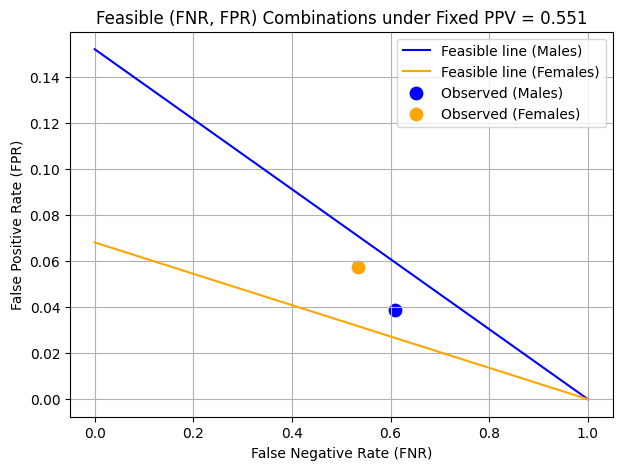

In [15]:
def feasible_fpr(fnr_array, p, ppv):
    """
    Given an array of FNR values in [0, 1],
    returns the corresponding FPR values from Chouldechova (2017), eq. (2.6).
    FPR = [p * (1 - FNR) * (1 - PPV)] / [1 - p]
    """
    return (p * (1 - fnr_array) * (1 - ppv)) / (1 - p)

# We'll sweep FNR from 0 to 1 for plotting
fnr_grid = np.linspace(0, 1, 200)

# Compute the feasible lines for each group, 
# using the *common* PPV for both
fpr_line_m = feasible_fpr(fnr_grid, p_m, common_ppv)
fpr_line_f = feasible_fpr(fnr_grid, p_f, common_ppv)

# Plot the feasible lines
plt.figure(figsize=(7,5))

plt.plot(fnr_grid, fpr_line_m, label="Feasible line (Males)", color="blue")
plt.plot(fnr_grid, fpr_line_f, label="Feasible line (Females)", color="orange")

# Plot the observed points for each group
plt.scatter(fnr_m, fpr_m, color="blue", marker="o", s=80, 
            label="Observed (Males)")
plt.scatter(fnr_f, fpr_f, color="orange", marker="o", s=80, 
            label="Observed (Females)")

plt.xlabel("False Negative Rate (FNR)")
plt.ylabel("False Positive Rate (FPR)")
plt.title("Feasible (FNR, FPR) Combinations under Fixed PPV = {:.3f}".format(common_ppv))
plt.legend()
plt.grid(True)
plt.show()


### Interpretation:
- The observed **FPR for females is higher than for males**, which suggests that the model is more likely to incorrectly classify low-income females as high-income.
- The **FNR for males is higher than for females**, meaning the model is missing more actual high-income males.
- If we wanted to **equalize FPR between groups**, we would have to **increase the FNR for males**, moving it further along the blue line. This trade-off shows the conflict or tension between different fairness goals.

This visualization illustrates that achieving equalized error rates across groups requires making trade-offs that may disproportionately impact different subgroups.

### Concluding Discussion

The ability to predict income levels has several potential applications in both **commercial and governmental settings**. Companies in **finance**, such as banks and credit card providers, could use this model to assess credit-worthiness, loan eligibility, or target specific financial products. **Marketing agencies** might use similar predictions to segment consumers for advertising high-end products or services. **Government agencies** could employ such models for economic policy analysis, workforce development, or social welfare program distribution.

However, deploying this model at a large scale carries significant risks, particularly concerning **fairness and bias**. Our bias audit revealed disparities in predictive performance across gender groups. Notably, the model has a **higher false positive rate (FPR) for females**, meaning it more often misclassifies lower-income women as high-income. Conversely, it has a **higher false negative rate (FNR) for males**, meaning it more frequently fails to recognize high-income males. If deployed in real-world scenarios such as hiring or loan approvals, this could **systematically disadvantage certain groups**, reinforcing existing economic inequalities.

Examining different **types of bias**, our model does not satisfy **error rate balance**, as FNR and FPR differ between genders. Additionally, the calibration of the model is problematic—**males have a higher precision (PPV) than females**, meaning the model is more confident in its positive predictions for men than for women. This suggests potential bias in how income is modeled, reflecting either societal disparities or weaknesses in the dataset itself.

Beyond bias, there are other concerns with deploying such a model. One key issue is **data representativeness**—the ACS dataset might not fully capture income distributions across different racial or socioeconomic groups. Additionally, there’s a risk of **automation bias**, where decision-makers might overly rely on model predictions without questioning their validity. Finally, **privacy concerns** arise when using sensitive demographic data for predictions, as such models could be exploited for discriminatory profiling.

To mitigate these issues, several steps could be taken:
- **Fairness constraints**: Adjusting the decision threshold per group to balance FPR and FNR.
- **Re-weighting techniques**: Ensuring training data better reflects underrepresented groups.
- **Explainability measures**: Making the model’s predictions more interpretable to reduce blind reliance.
- **Human oversight**: Keeping final decision-making in human hands rather than automating high-stakes outcomes.

finally, while predictive models can be powerful tools, deploying them responsibly requires **continuous auditing, transparency, and fairness interventions** to prevent unintended harm.